In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.model_selection import cross_val_predict



seed = pd.read_csv("seeds.csv")
y = seed["Type"]

#data preprocessing 

In [36]:
#1_checking for missing value
missing_value = seed.isnull().sum()
print(missing_value)



Area               0
Perimeter          0
Compactness        0
Kernel.Length      0
Kernel.Width       0
Asymmetry.Coeff    0
Kernel.Groove      0
Type               0
dtype: int64


In [37]:
#2_Check for duplicates
duplicate = seed.duplicated().sum()
print(duplicate)

0


In [54]:
print(seed['Type'].dtype)

int64


In [38]:
seed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             199 non-null    float64
 1   Perimeter        199 non-null    float64
 2   Compactness      199 non-null    float64
 3   Kernel.Length    199 non-null    float64
 4   Kernel.Width     199 non-null    float64
 5   Asymmetry.Coeff  199 non-null    float64
 6   Kernel.Groove    199 non-null    float64
 7   Type             199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [39]:
seed.head()

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [55]:
#3_Standardization
# Apply StandardScaler to standardize features.
# This scales each feature to have mean=0 and standard deviation=1, which improves performance
# of algorithms sensitive to feature scales like k-NN and Logistic Regression.
from sklearn.preprocessing import StandardScaler

X = seed.iloc[:, :-1]  # Select all columns except last (type)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Sample of standardized features:")
print(X_scaled[:5])

Sample of standardized features:
[[ 0.11716431  0.18679667  0.0081443   0.27085953  0.12313474 -1.00737062
  -0.40826475]
 [-0.01330197 -0.01975993  0.44234139 -0.20148088  0.17878306 -1.82718718
  -0.9454197 ]
 [-0.21586804 -0.38697165  1.46979786 -0.7958614   0.18938275 -0.68162472
  -1.21196249]
 [-0.37036759 -0.50172532  1.06139466 -0.72128133  0.3006794  -0.9814745
  -1.25265605]
 [ 0.41929676  0.30155033  1.40101417  0.03355933  0.78561481 -1.59752951
  -0.49982525]]


In [56]:
#4_check Class Balance
# Verify the class distribution to confirm the dataset is balanced.
# Balanced classes help avoid bias towards a particular class during model training.
class_counts = pd.Series(y).value_counts()
print("Class distribution:")
print(class_counts)

Class distribution:
Type
2    68
1    66
3    65
Name: count, dtype: int64


In [57]:
#dataf frame
scaled_features = pd.DataFrame(X_scaled, columns=seed.columns[:-1])

scaled_features[seed.columns[-1]] = seed[seed.columns[-1]]

print(scaled_features.head())
print(scaled_features.columns)


       Area  Perimeter  Compactness  Kernel.Length  Kernel.Width  \
0  0.117164   0.186797     0.008144       0.270860      0.123135   
1 -0.013302  -0.019760     0.442341      -0.201481      0.178783   
2 -0.215868  -0.386972     1.469798      -0.795861      0.189383   
3 -0.370368  -0.501725     1.061395      -0.721281      0.300679   
4  0.419297   0.301550     1.401014       0.033559      0.785615   

   Asymmetry.Coeff  Kernel.Groove  Type  
0        -1.007371      -0.408265     1  
1        -1.827187      -0.945420     1  
2        -0.681625      -1.211962     1  
3        -0.981475      -1.252656     1  
4        -1.597530      -0.499825     1  
Index(['Area', 'Perimeter', 'Compactness', 'Kernel.Length', 'Kernel.Width',
       'Asymmetry.Coeff', 'Kernel.Groove', 'Type'],
      dtype='object')


Model Evaluation Technique AND Choice of classifier

In [58]:
# Choose Logistic Regression because it works well with small, continuous datasets and is interpretable.
# k-NN is selected because it captures complex local patterns without assuming data distribution.

# Logistic Regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)


In [59]:
# Use Stratified 10-Fold Cross-Validation to evaluate the models.
# Stratification ensures each fold has proportional samples from all classes,
# which helps avoid biased evaluation especially on small datasets.

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n Befor FEATURE SELECTION \n")
# Logistic Regression
lr_scores = cross_val_score(lr, X_scaled, y, cv=skf, scoring='f1_macro')
print("Logistic Regression F1 Score:", lr_scores.mean())


lr_preds = cross_val_predict(lr, X_scaled, y, cv=skf)
print(" Logistic Regression Confusion Matrix:")
print(confusion_matrix(y, lr_preds))

# KNN
knn_scores = cross_val_score(knn, X_scaled, y, cv=skf, scoring='f1_macro')
print("KNN F1 Score:", knn_scores.mean())

knn_preds = cross_val_predict(knn, X_scaled, y, cv=skf)
print("KNN Confusion Matrix:")
print(confusion_matrix(y, knn_preds))


  


 Befor FEATURE SELECTION 

Logistic Regression F1 Score: 0.9487579087579089
 Logistic Regression Confusion Matrix:
[[60  2  4]
 [ 2 66  0]
 [ 2  0 63]]
KNN F1 Score: 0.9429084804084804
KNN Confusion Matrix:
[[60  2  4]
 [ 3 65  0]
 [ 2  0 63]]


Feature Selection

RFE for Logistic Regression AND SelectKBest for Knn

In [60]:
#models
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)

In [61]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def evaluate_model(model, X_data, y_data, name):
    f1 = cross_val_score(model, X_data, y_data, cv=skf, scoring='f1_macro')
    print(f"\n{name} F1 Score: {f1.mean():.4f}")

    cm_total = np.zeros((3, 3), dtype=int)
    for train_idx, test_idx in skf.split(X_data, y_data):
        model.fit(X_data.iloc[train_idx], y_data.iloc[train_idx])
        y_pred = model.predict(X_data.iloc[test_idx])
        cm_total += confusion_matrix(y_data.iloc[test_idx], y_pred)

    print(f"{name} Confusion Matrix:")
    print(cm_total)

In [62]:
# Apply Recursive Feature Elimination (RFE) and SelectKBest to try reducing feature space.
# Compare performance before and after feature selection to decide if removing features improves the model.
# RFE with Logistic Regression
rfe_lr = RFE(lr, n_features_to_select=3)
X_lr_selected = rfe_lr.fit_transform(X, y)

# SelectKBest with KNN
selector_knn = SelectKBest(score_func=f_classif, k=7)
X_knn_selected = selector_knn.fit_transform(X, y)


print("\n AFTER FEATURE SELECTION")
evaluate_model(lr, pd.DataFrame(X_lr_selected), y, "Logistic Regression (RFE)")
evaluate_model(knn, pd.DataFrame(X_knn_selected), y, "KNN (SelectKBest)")


 AFTER FEATURE SELECTION

Logistic Regression (RFE) F1 Score: 0.9030
Logistic Regression (RFE) Confusion Matrix:
[[57  4  5]
 [ 4 64  0]
 [ 6  0 59]]

KNN (SelectKBest) F1 Score: 0.8950
KNN (SelectKBest) Confusion Matrix:
[[54  4  8]
 [ 5 63  0]
 [ 3  0 62]]


In [65]:
# This code uses PCA to reduce the 7-feature data to 2D for visualization.
# Visualizing the data distribution supports model selection and understanding class separability.

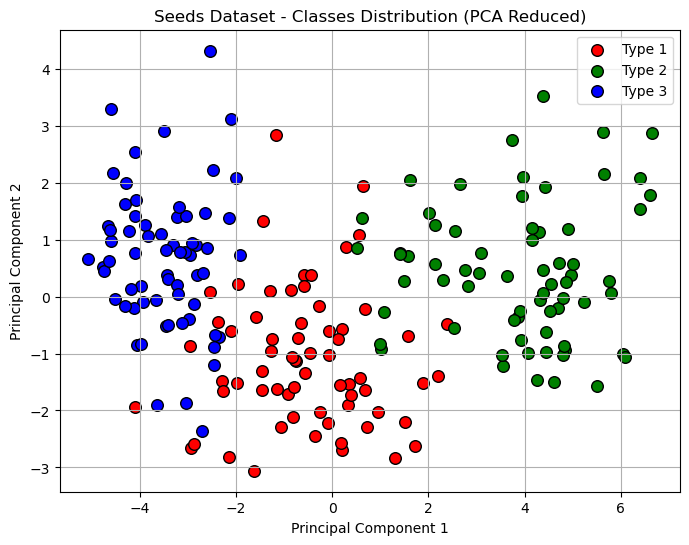

In [66]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



X = seed.drop(columns=['Type'])
y = seed['Type']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

colors = ['red', 'green', 'blue']
labels = ['Type 1', 'Type 2', 'Type 3']

plt.figure(figsize=(8,6))
for class_id, color, label in zip([1, 2, 3], colors, labels):
    plt.scatter(X_pca[y == class_id, 0], X_pca[y == class_id, 1], 
                c=color, label=label, edgecolor='k', s=70)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Seeds Dataset - Classes Distribution (PCA Reduced)')
plt.legend()
plt.grid(True)
plt.show()